In [1]:
from mpl_toolkits import mplot3d

import trimesh

import tensorflow as tf

#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
from scipy.io import loadmat

import os
from tqdm import tqdm_notebook as tqdm

from utils import coef2object, InvalidArgumentError, \
                default_render_params, create_render_params

MFM_DIR = "../PublicMM1/"
MFM_NAME = "01_MorphableModel.mat"

searching for scad in: /Users/gergelyflamich/Documents/Miscellaneous/MorphableFaceModel/mfm_venv/bin:/Users/gergelyflamich/Documents/Miscellaneous/MorphableFaceModel/mfm_venv/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/Apple/usr/bin:/Library/Apple/bin:/Library/TeX/texbin:/opt/X11/bin:/Applications/OpenSCAD.app/Contents/MacOS


In [2]:
# Load the MFM
if 'model' not in globals() or model is None:
    model = loadmat(MFM_DIR + MFM_NAME)
    model_size = {
        "n_shape_dim": model["shapePC"].shape[1],
        "n_tex_dim": model["texPC"].shape[1],
        "n_seg": model["segbin"].shape[1]
    }
    print("Loaded model!")
    
else:
    print("Model already loaded!")

Loaded model!


In [3]:
def display_face(shape, texture, triangulation, render_params):
    """
    Based on display_face.m provided in the University of Basel
    MFM package.
    """
   
    shape_size = np.prod(shape.shape)
    texture_size = np.prod(texture.shape)
    
    shape = shape.reshape((shape_size // 3, 3))
    texture = texture.reshape((texture_size // 3, 3))
    
    mesh = trimesh.Trimesh(vertices=shape,
                           faces=triangulation,
                           vertex_colors=texture)

    return mesh

In [25]:
alpha = np.random.normal(size=(model_size["n_shape_dim"], 1))
beta = np.random.normal(size=(model_size["n_tex_dim"], 1))

shape = coef2object(alpha, 
                    model["shapeMU"], 
                    model["shapePC"], 
                    model["shapeEV"])

texture = coef2object(beta, 
                      model["texMU"], 
                      model["texPC"], 
                      model["texEV"])

render_params = create_render_params(phi=0.5)

# The triangle indices are from Matlab, which means that they start at 1
# so we correct it
triangulation = model["tl"] - 1

# Quick fix to make the winding direction of the faces right
triangulation = triangulation[:, ::-1]

# face = display_face(shape=shape, 
#                      texture=texture, 
#                      triangulation=triangulation, 
#                      render_params=render_params)

#face.show()

# Projection

In [5]:
shape = shape.reshape((-1, 3))
texture = texture.reshape((-1, 3)) / 255.

# The TF code below performs the same operation as the code below:
#
#   # Create normals for the shape
#   normals = np.zeros_like(shape)

#   for tri in tqdm(triangulation):
    
#       # Calculate surface normal
#       vertices = shape[tri]
#       n = np.cross(vertices[0] - vertices[2], vertices[1] - vertices[0])
    
#       # Add surface normal to the area-weighted average for each vertex
#       normals[tri] += n
    
#   normals = normals / np.linalg.norm(normals, axis=1).reshape([-1, 1])

# Convert stuff to TF tensors
vertices = tf.convert_to_tensor(shape[triangulation])
triangulation = tf.convert_to_tensor(triangulation, dtype=tf.int32)

# Calculate surface normals, and then triple them so that we can perform the appropriate updates
surface_normals = tf.linalg.cross(vertices[:, 0, :] - vertices[:, 2, :], 
                                  vertices[:, 1, :] - vertices[:, 0, :])

surface_normals = tf.cast(tf.reshape(tf.tile(surface_normals, [1, 3]), [-1, 3]), tf.float32)

# Scatter the surface normals
vertex_normals = tf.zeros(shape.shape)
vertex_normals = tf.tensor_scatter_nd_add(vertex_normals, 
                                          tf.reshape(triangulation, [-1, 1]),
                                          surface_normals)
# Normalize
vertex_normals, _ = tf.linalg.normalize(vertex_normals, axis=1)

In [6]:
indices.shape[:-1] + normals_.shape[indices.shape[-1]:]

NameError: name 'indices' is not defined

In [5]:
def get_R_az(azimuth):
    
    az = azimuth * np.pi / 180
    
    caz = np.cos(az)
    saz = np.sin(az)
    
    return np.array([[caz, 0, -saz, 0],
                     [0, 1, 0, 0],
                     [saz, 0, caz, 0],
                     [0, 0, 0, 1]])

def get_R_el(elevation):
    
    el = elevation * np.pi / 180
    
    cel = np.cos(el)
    sel = np.sin(el)
    
    return np.array([[1, 0, 0, 0],
                     [0, cel, -sel, 0],
                     [0, sel, cel, 0],
                     [0, 0, 0, 1]])

def get_perspective_proj_mat(near, far, fov, aspect_ratio):
    
    tan_fov = np.tan(fov / 2)
    depth = far - near
    
    return np.array([[1. / (aspect_ratio * tan_fov), 0,                      0, 0],
                     [0,                  1. / tan_fov,                      0, 0],
                     [0,                             0, -(far + near) / depth, -1],
                     [0,                             0, -2 * far * near / depth, 0]])

def get_orthogonal_proj_mat(near, far, fov, aspect_ratio):
    
    top = np.tan(fov / 2) * near
    bottom = -top
    right = top * aspect_ratio
    left = -right
    
    width = right - left
    w_ratio = (left + right) / (right - left)
    
    height = top - bottom
    h_ratio = (top + bottom) / (top - bottom)
    
    depth = far - near
    d_ratio = (far + near) / (far - near)
    
    return np.array([[2 / width, 0, 0, 0],
                     [0, 2 / height, 0, 0],
                     [0, 0, -2 / depth, 0],
                     [-w_ratio, -h_ratio, -d_ratio, 1]])


def edge_fn(ax, ay, bx, by, px, py):    
    return (ax - bx) * (py - ay) - (ay - by) * (px - ax)

In [183]:
def cartesian_product(u, v):
    
    u = tf.reshape(u, [-1])
    v = tf.reshape(v, [-1])

    u, v = u[ None, :, None ], v[ :, None, None ]
    
    prod = tf.concat( [ u + tf.zeros_like( v ),
                        tf.zeros_like( u ) + v ], axis = 2 )
    return prod

class Rasterizer(tf.Module):
    
    def __init__(self, name="rasterizer"):
        
        super(Rasterizer, self).__init__(name=name)
        
        # ---------------------------------------------------
        # Non-trainable variables
        # ---------------------------------------------------
        
        # Image dimensions
        self.image_height = tf.Variable(1600, name="image_height", dtype=tf.int32, trainable=False)
        self.image_width = tf.Variable(1200, name="image_width", dtype=tf.int32, trainable=False)
        
        # Clipping planes
        self.near_plane = tf.Variable(0.1, name="near_plane", dtype=tf.float32, trainable=False)
        self.far_plane = tf.Variable(1000, name="far_plane", dtype=tf.float32, trainable=False)
        
        # Camera field of view angle
        self.field_of_view = tf.Variable(45, name="field_of_view", dtype=tf.float32, trainable=False)
        
        # Phong exponent
        self.eta = tf.Variable(20, dtype=tf.float32, name="phong_exponent", trainable=False)

        # Surface shininess
        self.surface_shininess = tf.Variable(0.1, dtype=tf.float32, name="surface_shininess", trainable=False)
        
        # ---------------------------------------------------
        # Trainable variables
        # ---------------------------------------------------
        
        self.camera_position = tf.Variable(np.array([0, 80000, -250000]), dtype=tf.float32, name="camera_pos")
        
        # Camera orientation
        self.azimuth = tf.Variable(180, dtype=tf.float32, name="azimuth")
        self.elevation = tf.Variable(-3, dtype=tf.float32, name="elevation")
        
        # Ambient light intensity: standard 18% intensity
        self.amb_light_int = tf.Variable(0.6 * np.array([1, 1, 1]), 
                                         dtype=tf.float32, 
                                         name="ambient_light_intensity")

        # Directional light
        # Intensity: white light
        self.dir_light_int = tf.Variable(0.6 * np.array([1, 1, 1]), 
                                         dtype=tf.float32, 
                                         name="directional_light_intensity" )

        # Direction
        self.dir_light_dir = tf.Variable(np.array([1, 1, 1]), 
                                         dtype=tf.float32, 
                                         name="directional_light_direction")
        
        # ---------------------------------------------------
        # Calculated quantities
        # ---------------------------------------------------
        self.aspect_ratio = self.image_width / self.image_height
                                             
        # normalize the light direction
        self.dir_light_dir, _ = tf.linalg.normalize(self.dir_light_dir) 
        
        
    def get_R_az(self):
    
        # Negate azimuth
        az = -self.azimuth * np.pi / 180

        caz = np.cos(az)
        saz = np.sin(az)

        return tf.convert_to_tensor([[caz, 0, -saz, 0],
                                     [0,   1,    0, 0],
                                     [saz, 0,  caz, 0],
                                     [0,   0,    0, 1]])

    def get_R_el(self):

        # Negate elevation
        el = -self.elevation * np.pi / 180

        cel = np.cos(el)
        sel = np.sin(el)

        return tf.convert_to_tensor([[1,   0,    0, 0],
                                     [0, cel, -sel, 0],
                                     [0, sel,  cel, 0],
                                     [0,   0,    0, 1]])
    
    def world_to_camera_mat(self):
        
        # Translation
        T = tf.concat((tf.reshape(self.camera_position, [1, 3]), [[1]]), axis=1)
        T = tf.concat(([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 1, 0]],
                                   T), axis=0)
        
        # Camera rotation
        R_az = self.get_R_az()
        R_el = self.get_R_el()

        R = tf.matmul(R_az, R_el)

        # World-to-Camera matrix
        world_to_camera = tf.matmul(R, T)
        
        return world_to_camera
    

    def perspective_proj_mat(self):

        tan_fov = np.tan(self.field_of_view / 2)
        
        near = self.near_plane
        far = self.far_plane
        ar = self.aspect_ratio
        
        depth = far - near

        return tf.convert_to_tensor([[1. / (ar * tan_fov),            0,                       0,  0],
                                     [0,                   1. / tan_fov,                       0,  0],
                                     [0,                              0,   -(far + near) / depth, -1],
                                     [0,                              0, -2 * far * near / depth,  0]], dtype=tf.float32)
    
    def calculate_vertex_normals(self, shape, triangulation):
        """
        The TF code below performs the same operation as the code below:
        
           # Create normals for the shape
           normals = np.zeros_like(shape)

           for tri in tqdm(triangulation):

               # Calculate surface normal
               vertices = shape[tri]
               n = np.cross(vertices[0] - vertices[2], vertices[1] - vertices[0])

               # Add surface normal to the area-weighted average for each vertex
               normals[tri] += n

           normals = normals / np.linalg.norm(normals, axis=1).reshape([-1, 1])
           
        """

        # Convert stuff to TF tensors
        vertices = tf.convert_to_tensor(shape[triangulation])
        triangulation = tf.convert_to_tensor(triangulation, dtype=tf.int32)

        # Calculate surface normals, and then triple them so that we can perform the appropriate updates
        surface_normals = tf.linalg.cross(vertices[:, 0, :] - vertices[:, 2, :], 
                                          vertices[:, 1, :] - vertices[:, 0, :])

        surface_normals = tf.cast(tf.reshape(tf.tile(surface_normals, [1, 3]), [-1, 3]), tf.float32)

        # Scatter the surface normals
        vertex_normals = tf.zeros(shape.shape)
        vertex_normals = tf.tensor_scatter_nd_add(vertex_normals, 
                                                  tf.reshape(triangulation, [-1, 1]),
                                                  surface_normals)
        # Normalize
        vertex_normals, _ = tf.linalg.normalize(vertex_normals, axis=1)
        
        return vertex_normals
        
        
    def rasterize(self, 
                  shape, 
                  texture, 
                  vertex_normals,
                  triangulation, 
                  render_parameters, 
                  perspective=True):
        
        shape = shape.reshape((-1, 3))
        texture = texture.reshape((-1, 3)) / 255.
        
        shape = tf.concat((shape, np.ones((shape.shape[0], 1))), axis=1)
        
        shape = tf.cast(shape, dtype=tf.float32)
        
        # -------------------------------------------------------
        # Projection Stage    
        # -------------------------------------------------------
        world_to_camera = self.world_to_camera_mat()
        
        if perspective:
            proj_mat = self.perspective_proj_mat()
            
        # TODO: orthographic projection
        else:
            proj_mat = tf.eye(4)
        
        tri_areas = tf.zeros(triangulation.shape[0])

        # Transform from world to camera coordinates
        camera_shape = tf.matmul(shape, world_to_camera)

        # Project to clip space
        clip_shape = tf.matmul(camera_shape, proj_mat)

        # Perspective divide: divide x, y, z by w
        ndc_shape = clip_shape[:, :3] / clip_shape[:, 3:]

        # Viewport transform
        viewport_x = (ndc_shape[:, 0] + 1) * 0.5 * (image_width - 1)
        # Invert along the vertical axis
        viewport_y = (1 - ndc_shape[:, 1]) * 0.5 * (image_height - 1)

        return viewport_x, viewport_y, ndc_shape[:, 2]
        # -------------------------------------------------------
        # Rasterization Stage    
        # -------------------------------------------------------
        
        # Get triangle coordinates
        triangles_x = viewport_x[triangulation]
        triangles_y = viewport_y[triangulation]
        triangles_z = ndc_shape[:, 2][triangulation]

        texture_red = texture[:, 0][triangulation]
        texture_green = texture[:, 1][triangulation]
        texture_blue = texture[:, 2][triangulation]

        vertex_normals = normals[triangulation]
        tri_vertices = shape[triangulation]

        for idx, (tri_x, tri_y, tri_z, red, green, blue, norms, verts) in \
            tqdm(enumerate(zip(triangles_x, 
                               triangles_y, 
                               triangles_z, 
                               texture_red, 
                               texture_green, 
                               texture_blue, 
                               vertex_normals,
                               tri_vertices))):

            # Build bounding box
            x_max = np.ceil(np.max(tri_x)).astype(np.int32)
            x_min = np.floor(np.min(tri_x)).astype(np.int32)

            y_max = np.ceil(np.max(tri_y)).astype(np.int32)
            y_min = np.floor(np.min(tri_y)).astype(np.int32)

            # Area of triangle = 0.5 * | side1 x side2 |
            area = edge_fn(ax=tri_x[0], 
                           ay=tri_y[0],
                           bx=tri_x[1],
                           by=tri_y[1],
                           px=tri_x[2],
                           py=tri_y[2])

            tri_areas[idx] = area * 0.5

            inv_tri_z = 1. / tri_z
            red_depth_ratio = red * inv_tri_z
            green_depth_ratio = green * inv_tri_z
            blue_depth_ratio = blue * inv_tri_z

            for col in range(x_min, x_max):
                if col < 0 or col >= image_width: continue

                for row in range(y_min, y_max):
                    if row < 0 or row >= image_height: continue

                    # Center of the pixel
                    col_ = col + 0.5
                    row_ = row + 0.5

                    lamb3 = edge_fn(ax=tri_x[0], 
                                    ay=tri_y[0],
                                    bx=tri_x[1],
                                    by=tri_y[1],
                                    px=col_,
                                    py=row_) / area

                    lamb1 = edge_fn(ax=tri_x[1], 
                                    ay=tri_y[1],
                                    bx=tri_x[2],
                                    by=tri_y[2],
                                    px=col_,
                                    py=row_) / area

                    lamb2 = edge_fn(ax=tri_x[2], 
                                    ay=tri_y[2],
                                    bx=tri_x[0],
                                    by=tri_y[0],
                                    px=col_,
                                    py=row_) / area

                    is_inside = lamb1 >= 0 and lamb2 >= 0 and lamb3 >= 0

                    if is_inside:

                        lamb = np.array([lamb1, lamb2, lamb3])

                        # Interpolate the z coordinate
                        pixel_z_coord = inv_tri_z.dot(lamb)


                        # check the z-buffer
                        if z_buffer[row, col] > pixel_z_coord:

                            z_buffer[row, col] = pixel_z_coord

                            image[row, col, 0] = pixel_z_coord * red_depth_ratio.dot(lamb)
                            image[row, col, 1] = pixel_z_coord * green_depth_ratio.dot(lamb)
                            image[row, col, 2] = pixel_z_coord * blue_depth_ratio.dot(lamb)

                            point_normal = lamb.reshape([1, -1]).dot(norms).ravel()
                            point_3d = lamb.reshape([1, -1]).dot(verts[:, :3]).ravel()

                            # Normalize the point normal
                            point_normal = point_normal / np.linalg.norm(point_normal)

                            # Calculate reflection direction:
                            # r = -l + 2(l.n)n
                            reflection_dir = -dir_light_dir + 2 * (dir_light_dir.dot(point_normal)) * point_normal

                            # Calculate viewing direction
                            view_dir = camera_position - point_3d
                            view_dir = view_dir / np.linalg.norm(view_dir)

                            # cosine of angle of incidence clamped to positive values only
                            incidence_cos = np.maximum(0, point_normal.dot(dir_light_dir))

                            # cosine angle between reflection direction and viewing direction clamped to positive values only
                            view_refl_cos = np.maximum(0, view_dir.dot(reflection_dir))

                            # Calculate point colour
                            diffuse_colour = (amb_light_int + dir_light_int * incidence_cos) * image[row, col, :]

                            specular_colour = surface_shininess * dir_light_int * view_refl_cos**eta

                            image[row, col, :] = diffuse_colour + specular_colour

In [26]:
shape = shape.reshape((-1, 3))
texture = texture.reshape((-1, 3)) / 255.

In [141]:
# ========================================
# Define Constants
# ========================================

# Image dimensions
image_height = 1600
image_width = 1200

# Clipping planes
near = 0.1
far = 1000

aspect_ratio = image_width / image_height

# 45 degrees FOV is a standard setting in video games
fov = 45

camera_position = np.array([0, 80000, -250000])

# Camera orientation
azimuth = 180
elevation = -3

# Ambient light intensity: standard 18% intensity
amb_light_int = 0.6 * np.array([1, 1, 1])

# Directional light
# intensity: white light
dir_light_int = 0.6 * np.array([1, 1, 1])

# direction
dir_light_dir = np.array([1, 1, 1])

# normalize the light direction
dir_light_dir = dir_light_dir / np.linalg.norm(dir_light_dir)

# Phong exponent
eta = 20

# Surface shininess
surface_shininess = 0.1

# ========================================
# Calculate translation matrices
# ========================================

r = Rasterizer()

P_ = r.perspective_proj_mat().numpy()
world_to_camera_ = r.world_to_camera_mat().numpy()

# Camera position (translation)
T = np.eye(4)
T[3, :3] = camera_position

# Camera rotation
R_az = get_R_az(-azimuth)
R_el = get_R_el(-elevation)

R = R_az.dot(R_el)

# World-to-Camera matrix
world_to_camera = R.dot(T)

# Perspective projector
P = get_perspective_proj_mat(near, far, fov, aspect_ratio)

In [230]:
vertex_normals = r.calculate_vertex_normals(shape, triangulation).numpy()

normals = vertex_normals

image = tf.zeros((image_height, image_width, 3))
z_buffer = np.inf * tf.ones((image_height, image_width))

viewport_x, viewport_y, clip_z = r.rasterize(shape, 
            texture, 
            vertex_normals,
            triangulation, 
            render_parameters=None, 
            perspective=True)


# Get triangle coordinates
triangles_x = viewport_x.numpy()[triangulation]
triangles_y = viewport_y.numpy()[triangulation]
triangles_z = clip_z.numpy()[triangulation]

texture_red = texture[:, 0][triangulation]
texture_green = texture[:, 1][triangulation]
texture_blue = texture[:, 2][triangulation]

vertex_normals = normals[triangulation]
tri_vertices = tf.convert_to_tensor(shape[triangulation], dtype=tf.float32)

tris_2d = tf.concat((tf.reshape(viewport_x, [-1, 1]), tf.reshape(viewport_y, [-1, 1])), axis=1)

# Calculate triangle areas

# Concatenate x and y coordinates together
vertices_2d = tf.concat((tf.reshape(viewport_x, [-1, 1]), tf.reshape(viewport_y, [-1, 1])), axis=1)

# Convert triangulation into a tensor
triangulation_ = tf.reshape(tf.convert_to_tensor(triangulation, dtype=tf.int32), [-1, 1])

# Select the corners of the triangles T x 3 x 2
tris_2d = tf.reshape(tf.gather_nd(vertices_2d, triangulation_), [-1, 3, 2])

# Get the corresponding z values for each triangle vertex for depth checks and interpolation
# Adding a 3rd dimension allows us to do broadcasted division later
tris_2d_z = tf.reshape(tf.gather_nd(clip_z, triangulation_), [-1, 3, 1])

# Convert the texture
texture_ = tf.convert_to_tensor(texture, dtype=tf.float32)
tris_texture = tf.reshape(tf.gather_nd(texture_, triangulation_), [-1, 3, 3])

# Append 0 z-coords such that we can take the cross product between sides
tris_2d_ = tf.concat((tris_2d, tf.zeros(tris_2d.shape.as_list()[:-1] + [1])), axis=2)

# The triangle areas are half the norm of the cross product between the appropriate edge vectors
# Since the edges are on the x-y plane, the cross product will only lie on the z axis 
# (x, y coords will be 0)
#
# We actually keep the factor of 2, because it will cancel later with the edge function's factor
tri_areas = tf.linalg.cross(tris_2d_[:, 0, :] - tris_2d_[:, 2, :], 
                            tris_2d_[:, 1, :] - tris_2d_[:, 0, :])[:, 2]

# Get triangle bounding boxes:
# 1. find the bounding box of each triangle
# 2. round the coordinates up/down to whole numbers
# 3. cast them to integers
tri_x_max = tf.cast(tf.math.ceil(tf.reduce_max(tris_2d[:, :, 0], axis=1)), dtype=tf.int32)
tri_x_min = tf.cast(tf.math.floor(tf.reduce_min(tris_2d[:, :, 0], axis=1)), dtype=tf.int32)

tri_y_max = tf.cast(tf.math.ceil(tf.reduce_max(tris_2d[:, :, 1], axis=1)), dtype=tf.int32)
tri_y_min = tf.cast(tf.math.floor(tf.reduce_min(tris_2d[:, :, 1], axis=1)), dtype=tf.int32)

# Calculate this for interpolation later
tri_2d_inv_z = 1. / tris_2d_z

texture_depth_ratio = tris_texture * tri_2d_inv_z

dir_light_dir = tf.reshape(tf.convert_to_tensor(dir_light_dir, dtype=tf.float32), [1, -1])
dir_light_int = tf.reshape(tf.convert_to_tensor(dir_light_int, dtype=tf.float32), [1, -1])
amb_light_int = tf.reshape(tf.convert_to_tensor(amb_light_int, dtype=tf.float32), [1, -1])
camera_position = tf.reshape(tf.convert_to_tensor(camera_position, dtype=tf.float32), [1, -1])


def rasterize_triangle(image,
                       z_buffer,
                       tri_index,
                       tri_x_max, 
                       tri_x_min, 
                       tri_y_max, 
                       tri_y_min, 
                       tris_2d, 
                       tris_inv_depth, 
                       tri_areas, 
                       tex_depth_ratios, 
                       vertex_normals, 
                       tri_vertices):
    
    x_max = tri_x_max[tri_index]
    x_min = tri_x_min[tri_index]
    y_max = tri_y_max[tri_index]
    y_min = tri_y_min[tri_index]
    tri_2d = tris_2d[tri_index]
    tri_inv_depth = tris_inv_depth[tri_index]
    tri_area = tri_areas[tri_index]
    tex_depth_ratio = tex_depth_ratios[tri_index]
    norms = vertex_normals[tri_index]
    verts = tri_vertices[tri_index]
    
    # The box points are the Cartesian product between the bounds
    x_coords = tf.range(x_min, x_max)
    y_coords = tf.range(y_min, y_max)
    
    box_points = cartesian_product(x_coords, 
                                   y_coords)
    
    box_points = tf.reshape(box_points, [-1, 2])

    # If the box point lies outside of the image, ignore them in the calculation
    min_bound_cond = tf.math.logical_and(box_points[:, 0] >= 0, box_points[:, 1] >= 0)
    max_bound_cond = tf.math.logical_and(box_points[:, 0] < image_width, box_points[:, 1] < image_height)

    in_image_indices = tf.where(tf.math.logical_and(min_bound_cond, max_bound_cond))
    
    # Perform actual filtering
    box_points = tf.gather_nd(box_points, in_image_indices)
    
    # Calculate stuff in the middle of the pixels
    box_points_centered = tf.cast(box_points, tf.float32) + 0.5

    
    
    # Append all 0 z dimension to box coordinates
    zeros_ = tf.zeros((tf.shape(box_points_centered)[0], 1))
    box_points_centered = tf.concat((box_points_centered, zeros_), axis=1)
    
    # Append all 0 z dimension to triangle vertices
    tri_2d_with_z = tf.concat((tri_2d, 
                               tf.zeros((tri_2d.shape.as_list()[0], 1))), axis=1)
    
    # Take cross product, such that we can get the barycentric coordinates of the box coordinates
    # The norm of the cross product is just the z dimension in this case
    lamb3s = tf.linalg.cross(tri_2d_with_z[1:2, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[:1, :])[:, 2] / tri_area
    
    lamb1s = tf.linalg.cross(tri_2d_with_z[2:, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[1:2, :])[:, 2] / tri_area
    
    lamb2s = tf.linalg.cross(tri_2d_with_z[:1, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[2:, :])[:, 2] / tri_area
    
    is_in_triangle_cond = tf.logical_and(lamb1s >=0,
                                         tf.logical_and(lamb2s >= 0,
                                                        lamb3s >= 0))
    is_in_triangle_indices = tf.where(is_in_triangle_cond) 
    
    # Filter box points based on whether they are in the triangle
    box_points = tf.gather_nd(box_points, is_in_triangle_indices)
    lamb1s = tf.gather_nd(lamb1s, is_in_triangle_indices)
    lamb2s = tf.gather_nd(lamb2s, is_in_triangle_indices)
    lamb3s = tf.gather_nd(lamb3s, is_in_triangle_indices)
    
    lambs = tf.stack((lamb1s, lamb2s, lamb3s), axis=1)
    
    # Interpolate the z coordinates
    box_point_depths = tf.reshape(tf.matmul(lambs, tri_inv_depth), [-1])
    
    # Check if the box points are visible
    z_buffer_at_box_points = tf.gather_nd(z_buffer, box_points)
    visible_point_indices = tf.where(z_buffer_at_box_points > box_point_depths)
    
    visible_points = tf.gather_nd(box_points, visible_point_indices)
    visible_box_point_depths = tf.gather_nd(box_point_depths, visible_point_indices)
    
    # Assign the new depths to the z-buffer
    z_buffer = tf.tensor_scatter_nd_update(z_buffer, visible_points, visible_box_point_depths)
    
    # Interpolate the colour of the pixels
    image_albedo = tf.reshape(visible_box_point_depths, [-1, 1]) * tf.matmul(lambs, tex_depth_ratio)
    
    # ----------------------------------------
    # Phong Lighting
    # ----------------------------------------
    
    # Interpolate vertex normals
    point_normals = tf.matmul(lambs, norms)
    point_normals, _ = tf.linalg.normalize(point_normals, axis=1)
    
    # Interpolate vertex coordinates in world space
    points_3d = tf.matmul(lambs, verts)
    
    # Calculate reflection direction:
    # r = -l + 2(l.n)n
    reflection_dirs = -dir_light_dir + 2 * tf.matmul(point_normals, tf.transpose(dir_light_dir)) * point_normals
    
    # Calculate viewing direction
    view_dirs = camera_position - points_3d
    view_dirs, _ = tf.linalg.normalize(view_dirs)
    
    # cosine of angle of incidence clamped to positive values only
    incidence_cos = tf.nn.relu(tf.matmul(point_normals, tf.transpose(dir_light_dir)))
    
    # cosine angle between reflection direction and viewing direction clamped to positive values only
    # Note: we are collapsing the second dimension with an inner product
    view_refl_cos = tf.reshape(tf.nn.relu(tf.einsum("ij,ij->i", view_dirs, reflection_dirs)), [-1, 1])
    
    # Calculate point colour
    diffuse_colour = (amb_light_int + tf.matmul(incidence_cos, dir_light_int)) * image_albedo
    
    specular_colour = surface_shininess * tf.matmul(view_refl_cos, dir_light_int)**eta
    
    colour = diffuse_colour + specular_colour
    
    # Update the image
    image = tf.tensor_scatter_nd_update(image, visible_points, colour)
    
    return [image, 
            z_buffer,
            tri_index + 1]



tri_index = tf.constant(0)    
loop_cond = lambda im, zbuf, tri_index: tri_index < triangulation.shape[0]
loop_body = lambda im, zbuf, idx: rasterize_triangle(im, zbuf, idx,
                                                     tri_x_max=tri_x_max, 
                                                     tri_x_min=tri_x_min, 
                                                     tri_y_max=tri_y_max, 
                                                     tri_y_min=tri_y_min, 
                                                     tris_2d=tris_2d, 
                                                     tris_inv_depth=tri_2d_inv_z, 
                                                     tri_areas=tri_areas, 
                                                     tex_depth_ratios=texture_depth_ratio, 
                                                     vertex_normals=vertex_normals, 
                                                     tri_vertices=tri_vertices)    

res = tf.while_loop(loop_cond, 
                    loop_body, 
                    loop_vars=[image, z_buffer, tri_index], 
                    shape_invariants=[image.get_shape(), z_buffer.get_shape(), tri_index.get_shape()],)

InvalidArgumentError: Outer dimensions of indices and update must match. Indices shape: [1,2], updates shape:[2,3] [Op:TensorScatterUpdate]

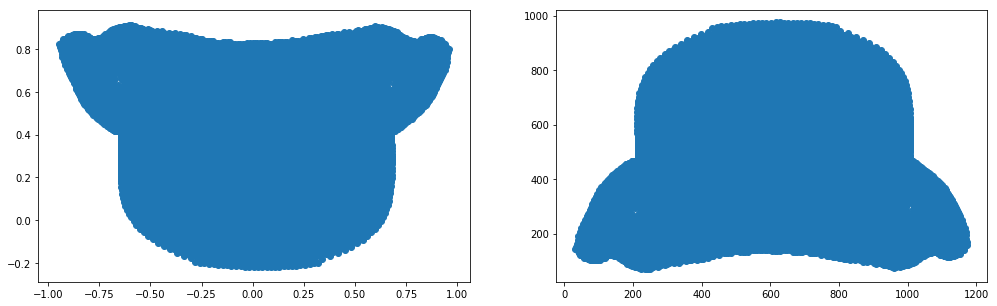

In [11]:
plt.figure(figsize=(17, 5))

plt.subplot(121)
plt.scatter(ndc_shape[:, 0], ndc_shape[:, 1])

plt.subplot(122)
plt.scatter(viewport_x, viewport_y)

plt.show()

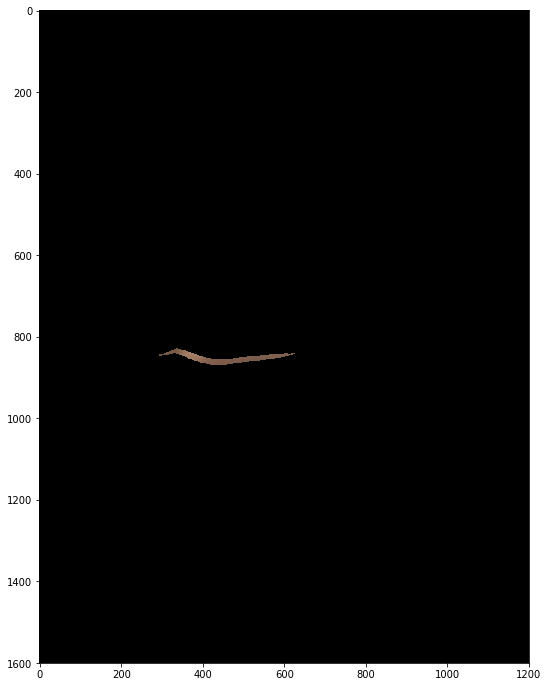

In [231]:
plt.figure(figsize=(16, 12))
plt.imshow(res[0].numpy())

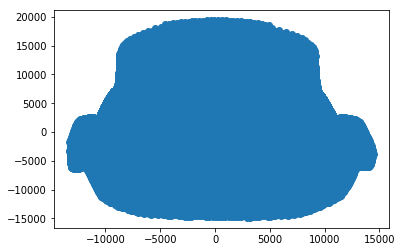

In [72]:
plt.scatter(clip_shape[:, 0], clip_shape[:, 1])

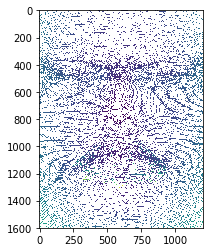

In [107]:
plt.imshow(z_buffer)

In [286]:
p_ = p_ / p_[:, 3:]

In [47]:
elems = tf.Variable(np.array([1, 2, 3, 4, 5, 6]), dtype=tf.float32)

with tf.GradientTape() as tape:
    squares = tf.map_fn(lambda x: x * x * x, elems)

tape.gradient(squares, (elems,))

(<tf.Tensor: id=2099, shape=(6,), dtype=float32, numpy=array([  3.,  12.,  27.,  48.,  75., 108.], dtype=float32)>,)

In [ ]:
# Transform from world to camera coordinates
camera_shape = shape.dot(world_to_camera)

# Project to clip space
clip_shape = camera_shape.dot(P)

# Currently don't clip here. We take the extra overhead so that we don't need to
# perform a difficult conditional check for visible triangles
# Perform clipping
# clip_cond = np.where((np.abs(clip_shape[:, 0]) <= clip_shape[:, 3]) * 
#                     (np.abs(clip_shape[:, 1]) <= clip_shape[:, 3]) * 
#                     (np.abs(clip_shape[:, 2]) <= clip_shape[:, 3]) * 
#                     (clip_shape[:, 3] > 0))[0]

# clipped_shape = clip_shape[clip_cond, :]

# Perspective divide: divide x, y, z by w
ndc_shape = clip_shape[:, :3] / clip_shape[:, 3:]

# Viewport transform
viewport_x = (ndc_shape[:, 0] + 1) * 0.5 * (image_width - 1)
# Invert along the vertical axis
viewport_y = (1 - ndc_shape[:, 1]) * 0.5 * (image_height - 1)

# Get triangle coordinates
triangles_x = viewport_x[triangulation]
triangles_y = viewport_y[triangulation]
triangles_z = ndc_shape[:, 2][triangulation]

texture_red = texture[:, 0][triangulation]
texture_green = texture[:, 1][triangulation]
texture_blue = texture[:, 2][triangulation]

vertex_normals = normals[triangulation]
tri_vertices = shape[triangulation]

   for col in range(x_min, x_max):
        if col < 0 or col >= image_width: continue
            
        for row in range(y_min, y_max):
            if row < 0 or row >= image_height: continue
            
            # Center of the pixel
            col_ = col + 0.5
            row_ = row + 0.5
            
            lamb3 = edge_fn(ax=tri_x[0], 
                            ay=tri_y[0],
                            bx=tri_x[1],
                            by=tri_y[1],
                            px=col_,
                            py=row_) / area
            
            lamb1 = edge_fn(ax=tri_x[1], 
                            ay=tri_y[1],
                            bx=tri_x[2],
                            by=tri_y[2],
                            px=col_,
                            py=row_) / area
            
            lamb2 = edge_fn(ax=tri_x[2], 
                            ay=tri_y[2],
                            bx=tri_x[0],
                            by=tri_y[0],
                            px=col_,
                            py=row_) / area
            
            is_inside = lamb1 >= 0 and lamb2 >= 0 and lamb3 >= 0
            
            if is_inside:
                    
                lamb = np.array([lamb1, lamb2, lamb3])
                
                # Interpolate the z coordinate
                pixel_z_coord = inv_tri_z.dot(lamb)
                
                
                # check the z-buffer
                if z_buffer[row, col] > pixel_z_coord:
                    
                    z_buffer[row, col] = pixel_z_coord
                    
                    image[row, col, 0] = pixel_z_coord * red_depth_ratio.dot(lamb)
                    image[row, col, 1] = pixel_z_coord * green_depth_ratio.dot(lamb)
                    image[row, col, 2] = pixel_z_coord * blue_depth_ratio.dot(lamb)
                    
                    point_normal = lamb.reshape([1, -1]).dot(norms).ravel()
                    point_3d = lamb.reshape([1, -1]).dot(verts[:, :3]).ravel()
                    
                    # Normalize the point normal
                    point_normal = point_normal / np.linalg.norm(point_normal)
                    
                    # Calculate reflection direction:
                    # r = -l + 2(l.n)n
                    reflection_dir = -dir_light_dir + 2 * (dir_light_dir.dot(point_normal)) * point_normal
                    
                    # Calculate viewing direction
                    view_dir = camera_position - point_3d
                    view_dir = view_dir / np.linalg.norm(view_dir)
                    
                    # cosine of angle of incidence clamped to positive values only
                    incidence_cos = np.maximum(0, point_normal.dot(dir_light_dir))
                    
                    # cosine angle between reflection direction and viewing direction clamped to positive values only
                    view_refl_cos = np.maximum(0, view_dir.dot(reflection_dir))
                    
                    # Calculate point colour
                    diffuse_colour = (amb_light_int + dir_light_int * incidence_cos) * image[row, col, :]
                    
                    specular_colour = surface_shininess * dir_light_int * view_refl_cos**eta
                    
                    image[row, col, :] = diffuse_colour + specular_colour

# for idx, (tri_x, tri_y, tri_z, red, green, blue, norms, verts) in \
#     tqdm(enumerate(zip(triangles_x, 
#                        triangles_y, 
#                        triangles_z, 
#                        texture_red, 
#                        texture_green, 
#                        texture_blue, 
#                        vertex_normals,
#                        tri_vertices))):
    
#     rasterize_triangle(tri_x, tri_y, tri_z, red, green, blue, norms, verts)